# The trapezoidal rule: vectorization and perormance

Here we discuss in detail the performance profile of various solutions to the exercise from our Numpy introduction, the trapezoidal rule for the numerical approximation of definite integrals.

If we denote by $x_{i}$ ($i=0,\ldots,n,$ with $x_{0}=a$ and $x_{n}=b$) the abscissas
where the function is sampled, then

$$\int_{a}^{b}f(x)dx\approx\frac{1}{2}\sum_{i=1}^{n}\left(x_{i}-x_{i-1}\right)\left(f(x_{i})+f(x_{i-1})\right).$$

The common case of using equally spaced abscissas with spacing $h=(b-a)/n$ reads:

$$\int_{a}^{b}f(x)dx\approx\frac{h}{2}\sum_{i=1}^{n}\left(f(x_{i})+f(x_{i-1})\right).$$

One frequently receives the function values already precomputed, $y_{i}=f(x_{i}),$ so the formula becomes

$$\int_{a}^{b}f(x)dx\approx\frac{1}{2}\sum_{i=1}^{n}\left(x_{i}-x_{i-1}\right)\left(y_{i}+y_{i-1}\right).$$

In this exercise, you'll need to write two functions, `trapz` and `trapzf`. `trapz` applies the trapezoid formula to pre-computed values, implementing equation trapz, while `trapzf` takes a function $f$ as input, as well as the total number of samples to evaluate, and computes the equation above.

Test it and show that it produces correct values for some simple integrals you can compute analytically or compare your answers against `scipy.integrate.trapz`, using as test function $f(x)$:

$$
f(x) = (x-3)(x-5)(x-7)+85
$$

integrated between $a=1$ and $b=9$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sint

In [2]:
def f(x):
    return (x-3)*(x-5)*(x-7)+85

a, b, n = (1, 9, 200)
x = np.linspace(a, b, n)
y = f(x)

print("Reference value (trapezoid):", sint.trapz(y, x))

Reference value (trapezoid): 680.0


In [3]:
def trapz(y, x):
    return 0.5*((x[1:]-x[:-1])*(y[1:]+y[:-1])).sum()

def trapzf(f, a, b, n):
    x = np.linspace(a, b, n)
    # Sample the input function at all values of x
    y = f(x)
    # Note that in the equations above, the list had n+1 points. Since here we're using
    # n as the total number of points, the actual size of the interval h should 
    # use n-1 in the formula:
    h = (b-a)/(n-1)
    # Compute the trapezoid rule sum for the final result
    return (h/2)*(y[1:]+y[:-1]).sum()

print("Our functions")
print(trapz(y, x))
print(trapzf(f, a, b, n))

Our functions
680.0
680.0


## Some performance notes

Let's compare the time it takes to compute the fully vectorized form in our `trapz` with a more manual implementation that does the computation with a pure Python loop.

In [4]:
def trapzl(y, x):
    "Pure python version of trapezoid rule."
    s = 0
    for i in range(1, len(x)):
        s += (x[i]-x[i-1])*(y[i]+y[i-1])
    return s/2

trapzl(y, x)

680.00000000000011

Let's compute this over a much finer grid to really see the performance difference

In [5]:
a, b, n = (1, 9, 20_000)
x = np.linspace(a, b, n)
y = f(x)

tv = %timeit -o trapz(y, x)
tl = %timeit -o trapzl(y, x)

35.2 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.8 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The output of `%timeit` is a special `TimeitResult` object that contains all the information about the timing run in a set of attributes. Try typing `tv.<TAB>` to see some of its attributes.

In [6]:
tv

<TimeitResult : 35.2 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In particular, we can look at the average run time, which as we can see, is in seconds:

In [7]:
tv.average

3.5238153685661796e-05

With this, we can now see how much faster the Numpy version was at 20,000 sample points:

In [8]:
tl.average/tv.average

306.7110725043031

Let's see what the performance difference is across a range of sizes (note this will take a while to run). We're actually going to need the same computation of $x$ and $f(x)$ over and over, so let's do it once and retrieve them later on:

In [9]:
a, b = 1, 9

xy = []
sizes = np.logspace(1, 7, 7)
for n in sizes:
    x = np.linspace(a, b, int(n))
    y = f(x)
    xy.append((x, y))

In [10]:
tv, tl = [], []
tve, tle = [], []
for x, y in xy:
    t1 = %timeit -o trapz(y, x)
    tv.append(t1.average)
    tve.append(t1.stdev)
    t2 = %timeit -o trapzl(y, x)
    tl.append(t2.average)
    tle.append(t2.stdev)

tva = np.array(tv); tvea = np.array(tve)
tla = np.array(tl); tlea = np.array(tle)

3.43 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.46 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.72 µs ± 219 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
52.4 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.49 µs ± 89 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
514 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.3 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.29 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
144 µs ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
51.7 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.56 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
548 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
71.7 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.18 s ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop 

Now let's plot these, along with proper error bars (remember your error propagation formulas, assuming here that the measurements are normal IID for simplicity):

In [11]:
def rat_err(p, dp, q, dq):
    ratio = p/q
    err = ratio*np.sqrt((dp/p)**2 + (dq/q)**2)
    return ratio, err

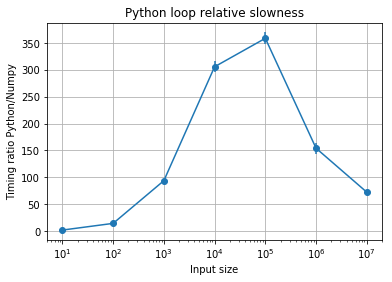

In [12]:
ratio, err = rat_err(tla, tlea, tva, tvea)

plt.errorbar(sizes, ratio, yerr=err, fmt = 'o-')
plt.xscale('log')

plt.grid(True)
plt.xlabel("Input size")
plt.ylabel("Timing ratio Python/Numpy")
plt.title("Python loop relative slowness");

A few observations:

- At very small sizes the difference isn't very dramatic. The overhead of the Python function call and basic arithmetic dominates.

- For input sizes ranging from the thousands to the million elements, the vectorized version can be ~ 100x to ~300x fastr than the pure Python loop.  This is not uncommon in real-world applications.

- At very large sizes (at a million) the performance profile changes.

- There's significant uncertainty for one of the values but little for the others, and even accounting for that uncertainty, the conclusion doesn't fundamentally change.

In general it's extremely hard to predict exact performance ratios, which often vary in hard to understand ways with problem size, as hardware, cache and algorithm specifics intersect.  But the results of this example aren't suprising: whether exactly 100x or 350x slower, the fact remains that the vectorized solution vastly outperforms a pure Python loop.  This is a key aspect of Numpy as a key piece of high-performance Python.

For an in-depth look at the "vectorized mindset" for Numpy, Nicolas Rougier has written the excellent (and free!) book ["From Python to Numpy"](http://www.labri.fr/perso/nrougier/from-python-to-numpy).

## Numba

Let's have a look at how [Numba](https://numba.pydata.org) can help in this type of loop-intensive code.

In [13]:
from numba import jit

trapzn = jit(trapzl)

x = np.linspace(a, b, 200)
y = f(x)

trapzn(y, x)

680.0000000000001

In [14]:
x = np.linspace(a, b, 20_000)
y = f(x)

%timeit trapz(y, x)
%timeit trapzn(y, x)

34.6 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
22.5 µs ± 732 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


That's pretty impressive! By simply *compiling* our slow, Python code, we get it to beat the Numpy version at a size of 200.

Let's collect Numba performance numbers similarly to the code above, and make a plot comparing Numba to Numpy at the same sizes:

In [15]:
tn, tne = [], []
for x, y in xy:
    t = %timeit -o trapzn(y, x)
    tn.append(t.average)
    tne.append(t.stdev)

tna = np.array(tn)
tnea = np.array(tne)

413 ns ± 4.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
512 ns ± 11.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.56 µs ± 25.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
11.3 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
110 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.16 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13 ms ± 948 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's look at the Numba data alongside the Python one:

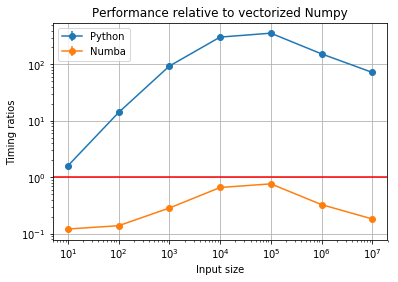

In [16]:
rp, ep = rat_err(tla, tlea, tva, tvea)
rn, en = rat_err(tna, tnea, tva, tvea)

plt.errorbar(sizes, rp, yerr=ep, fmt = 'o-', label="Python")
plt.errorbar(sizes, rn, yerr=en, fmt = 'o-', label="Numba")
plt.xscale('log')
plt.yscale('log')

plt.grid(True)
plt.axhline(1, color='red')
plt.legend()
plt.xlabel("Input size")
plt.ylabel("Timing ratios")
plt.title("Performance relative to vectorized Numpy");

Let's quickly see the Numba/Numpy ratios (the raw numbers):

In [17]:
print(tna/tva)
print(tva/tna)  # Let's look at the reverse relation, which may be a bit easier to interpret

[ 0.12029788  0.13762593  0.28367041  0.65578777  0.76074653  0.32554678
  0.18141704]
[ 8.31269874  7.26607237  3.52521785  1.52488357  1.31449828  3.07175515
  5.51216148]


Some quick thoughts:

- The Numba performance is *always* better than Numpy.  Note that this is a pretty ideal case for Numpy, and we did exactly *nothing* to the Python code other than compile it with `numba.jit`.  We're basically getting better-than-numpy performance for free.  Nubma can be a bit like magic ([this blog post](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/) by Jake VanderPlas contains much more detail).

- In some cases, the difference is quite remarkable. On the other hand, where Numpy performs best comapred to raw Python, Numba still beats it but not by too much.  This probably indicates Numpy is already nearly optimal in that range.


Let's look at the actual times instead, which in this case can be informative:

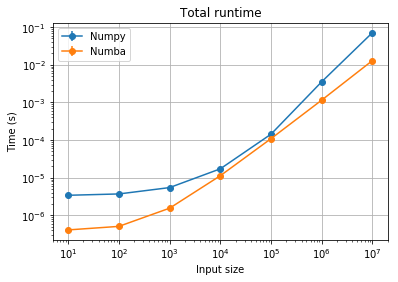

In [18]:
plt.errorbar(sizes, tva, yerr=tvea, fmt='o-', label="Numpy")
plt.errorbar(sizes, tna, yerr=tnea, fmt='o-', label="Numba")
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.xlabel("Input size")
plt.ylabel("Time (s)")
plt.title("Total runtime");

We see that the runtime profile is more smoothly linear (as it should be) for the Numba code.

## Exercise: Numba atop Numpy?

Let's make `trapznv` which is a Numba-fied version of `trapz`, the Numpy version. The question is: can Numba be of any benefit on a function that is already a single Numpy expression? Let's see...

In [19]:
trapznv = jit(trapz)

x = np.linspace(a, b, 200)
y = f(x)

trapznv(y, x)

680.0000000000001

Now that we see it's correct, let's look at performance in just one case:

In [20]:
%timeit trapz(y, x)
%timeit trapznv(y, x)

4.19 µs ± 97.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.04 µs ± 22.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
tnv, tnve = [], []
for x, y in xy:
    t = %timeit -o trapznv(y, x)
    tnv.append(t.average)
    tnve.append(t.stdev)

tnva = np.array(tnv)
tnvea = np.array(tnve)

631 ns ± 3.56 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
839 ns ± 13.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.84 µs ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
23.5 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
228 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.49 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.7 ms ± 842 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


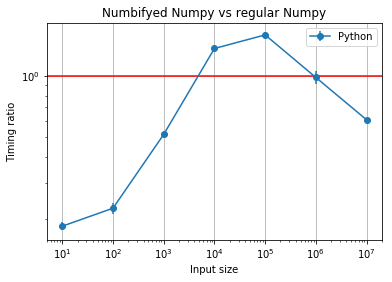

In [22]:
r, e = rat_err(tnva, tnvea, tva, tvea)

plt.errorbar(sizes, r, yerr=e, fmt='o-', label="Python")
plt.xscale('log')
plt.yscale('log')

plt.grid(True)
plt.axhline(1, color='red')
plt.legend()
plt.xlabel("Input size")
plt.ylabel("Timing ratio")
plt.title("Numbifyed Numpy vs regular Numpy");

## Numerical accuracy

We should finally take a quick look at accuracy considerations. In this case we know the exact answer (680), so we can see how each method compares. As $n \rightarrow \infty$ we expect them all to converge to 680, but let's see if any of them accumulates error worse than the others.  Remember, since the Numba version is algorithmically nothing but the Python code, any differences between Python and Numba would be due to Numba's compilation/optimizations:

In [23]:
def err(val, exact=680):
    return abs((val-exact)/exact)

# This time, let's make empty arrays and fill them in
epy = np.empty_like(sizes)
enpy = np.empty_like(sizes)
enba = np.empty_like(sizes)

for i, (x, y) in enumerate(xy):
    epy[i] = err(trapzl(y, x))
    enpy[i] = err(trapz(y, x))
    enba[i] = err(trapzn(y, x))

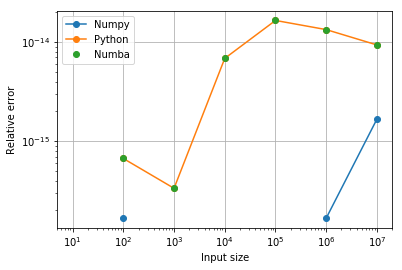

In [24]:
plt.loglog(sizes, enpy, 'o-', label='Numpy')
plt.loglog(sizes, epy, 'o-', label='Python')
plt.loglog(sizes, enba, 'o', label='Numba')
plt.legend()
plt.grid()
plt.xlabel("Input size")
plt.ylabel("Relative error");

Fortunately, we see that Numba produces identical results to Pure Python (good news: its optimizations don't change the results).  Furthermore, while we see a small loss of accuracy relative to Numpy's [high accuracy summation algorithm](https://github.com/numpy/numpy/pull/3685), the error is $\cal{O}(10^{-14})$, which is still close to floating-point precision.